In [84]:
import os 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

# 1. Data Acquisition

We read each patient in the train and test folder given the path.   
For the rest of this section, all visualizations will be done on the first patient in the training dictionary.

In [85]:
def read_train_test_folder(path='resources'):
    patient_files = [patient for patient in os.listdir(path) if patient.endswith('.csv')]
    patient_dict = {}

    for index,patient in enumerate(patient_files):
        patient_dict[index] = pd.read_csv(os.path.join(path,patient))
    
    return patient_dict

In [86]:
TRAIN_PATH = 'resources/Ohio2020_processed/train'
TEST_PATH = 'resources/Ohio2020_processed/test'

In [87]:
train_dict = read_train_test_folder(TRAIN_PATH)
test_dict = read_train_test_folder(TEST_PATH)

In [88]:
train_dict[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13109 entries, 0 to 13108
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   5minute_intervals_timestamp  13109 non-null  float64
 1   missing_cbg                  13109 non-null  float64
 2   cbg                          11946 non-null  float64
 3   finger                       553 non-null    float64
 4   basal                        13089 non-null  float64
 5   hr                           0 non-null      float64
 6   gsr                          5981 non-null   float64
 7   carbInput                    73 non-null     float64
 8   bolus                        304 non-null    float64
dtypes: float64(9)
memory usage: 921.9 KB


In [89]:
train_dict[0].describe()

,5minute_intervals_timestamp,missing_cbg,cbg,finger,basal,hr,gsr,carbInput,bolus
count,1.310900e+04,13109.000000,11946.000000,553.000000,13089.000000,0.0,5981.000000,73.000000,304.000000
mean,6.042310e+06,0.088718,137.102294,107.788427,0.463025,NaN,0.849838,59.178082,4.015789
std,3.784690e+03,0.284347,55.027075,84.550134,0.309976,NaN,4.677923,29.755645,2.861364
min,6.035755e+06,0.000000,40.000000,0.000000,0.000000,NaN,0.000000,1.000000,0.100000
25%,6.039033e+06,0.000000,94.000000,0.000000,0.400000,NaN,0.024371,30.000000,2.000000
50%,6.042310e+06,0.000000,127.000000,102.000000,0.400000,NaN,0.073261,57.000000,3.200000
75%,6.045587e+06,0.000000,171.000000,164.000000,0.400000,NaN,0.251630,85.000000,5.425000
max,6.048864e+06,1.000000,369.000000,315.000000,2.100000,NaN,71.035749,100.000000,11.400000


<h2> 1.2 Continuous Blood Glucose Visualization

Plot of the $\textbf{Continuous Blood Glucose}$ parameter of patient 0 for 1000 time instances.   
When the whole CBG is plotted, it is not clearly visible the peaks that are cut due to the $[40,400]$ limits.

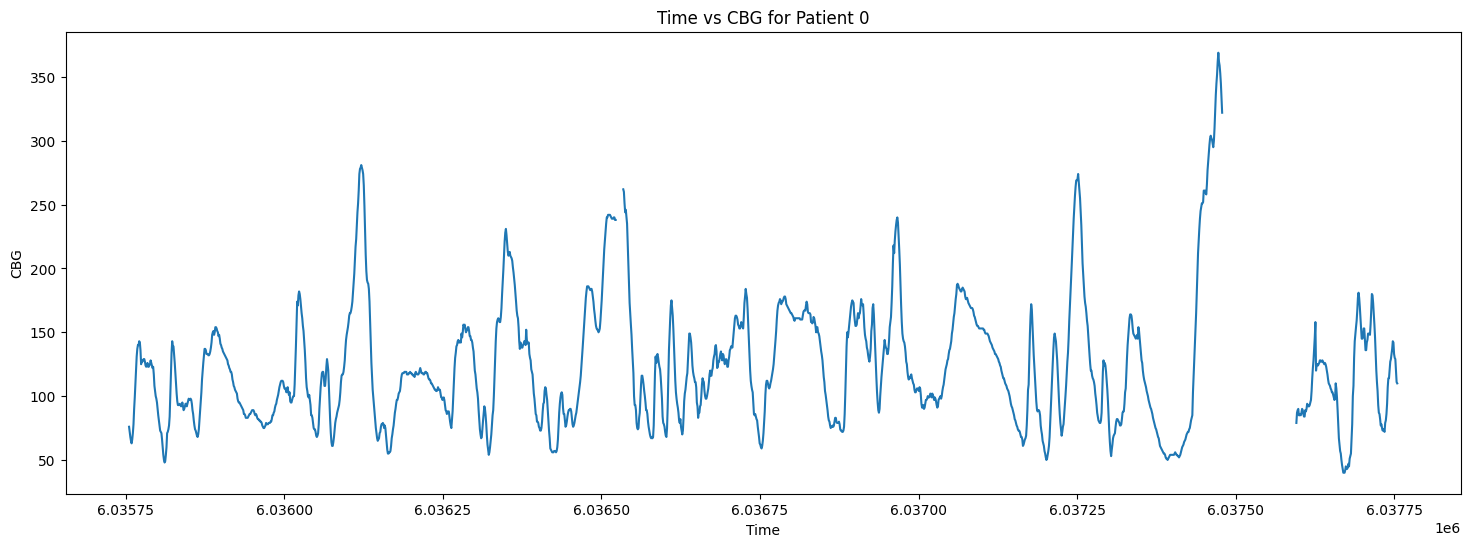

In [101]:
plt.figure(figsize=(18,6))
plt.plot(train_dict[0]["5minute_intervals_timestamp"][:2000],train_dict[0]["cbg"][:2000],label="Patient 0")
plt.title(f'Time vs CBG for Patient 0')
plt.xlabel("Time")
plt.ylabel("CBG")
plt.show()

<h2> 1.3 Correlation Matrix between Continuous Blood Glucose and other features

In [91]:
# using iloc to exclude the first column(time stamp) from correlation matrix 
corr_matrix = train_dict[0].iloc[:,1:].corr()

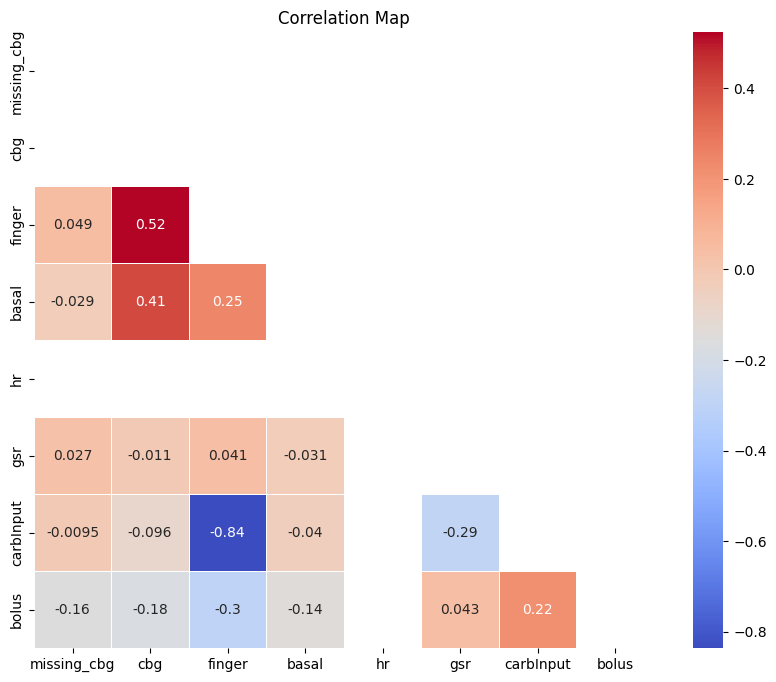

In [92]:
plt.figure(figsize=(10,8))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix,mask=mask,annot=True,cmap='coolwarm',linewidths=0.5)
plt.title("Correlation Map")
plt.show()

# 2. Data Pre-Processing

In [96]:
percentile_80 = train_dict[0]["cbg"].quantile(0.8)
print("Percentile 80: ", percentile_80)

Percentile 80:  182.0


In [97]:
percentile_80_patient0 = train_dict[0][train_dict[0]["cbg"] < percentile_80]

percentile_80_patient0

,5minute_intervals_timestamp,missing_cbg,cbg,finger,basal,hr,gsr,carbInput,bolus
0,6.035755e+06,0.0,76.0,80.0,NaN,NaN,0.337214,NaN,NaN
1,6.035756e+06,0.0,72.0,NaN,NaN,NaN,0.317671,NaN,NaN
2,6.035757e+06,0.0,68.0,NaN,NaN,NaN,0.342821,NaN,NaN
3,6.035758e+06,0.0,65.0,NaN,NaN,NaN,0.359941,NaN,NaN
4,6.035759e+06,0.0,63.0,NaN,NaN,NaN,0.365833,NaN,NaN
...,...,...,...,...,...,...,...,...,...
13013,6.048769e+06,0.0,170.0,NaN,0.4,NaN,12.068299,NaN,NaN
13014,6.048770e+06,0.0,174.0,NaN,0.4,NaN,10.458800,NaN,NaN
13015,6.048771e+06,0.0,178.0,NaN,0.4,NaN,11.378005,NaN,NaN
13016,6.048772e+06,0.0,179.0,NaN,0.4,NaN,13.001140,NaN,NaN


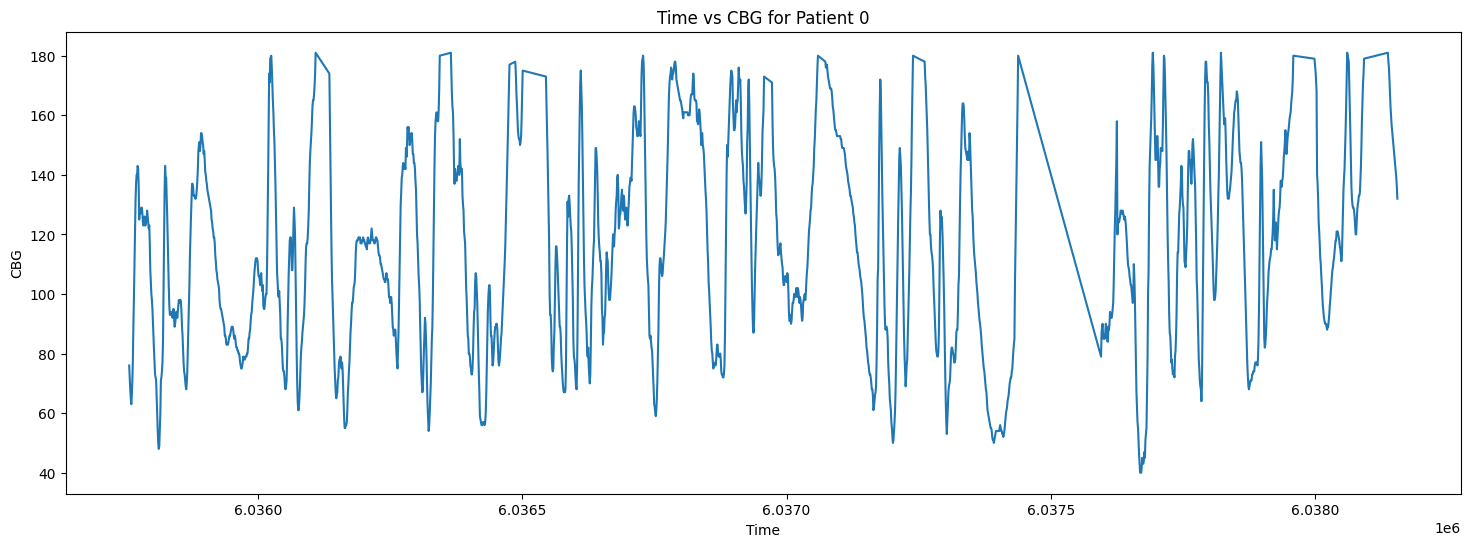

In [102]:
plt.figure(figsize=(18,6))
plt.plot(percentile_80_patient0["5minute_intervals_timestamp"][:2000],percentile_80_patient0["cbg"][:2000],label="Patient 0")
plt.title(f'Time vs CBG for Patient 0')
plt.xlabel("Time")
plt.ylabel("CBG")
plt.show()

<h2> Train, Test Splitting 

The 80th perc